In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [79]:
[1,2,3,4][0:-0]

[2, 3]

In [231]:
class Correlator:
    
    def __init__(self):
        self.image = None
        self.filter = None

    def __padding(self, horizontal_padding, vertical_padding):
        padded_image = np.zeros((self.image.shape[0] + 2 * vertical_padding, self.image.shape[1] + 2 * horizontal_padding, 3))
        
        if vertical_padding == 0:
            padded_image[:, horizontal_padding : -horizontal_padding, :] = self.image 
        elif horizontal_padding == 0:
            padded_image[vertical_padding : -vertical_padding, :, :] = self.image 
        else:
            padded_image[vertical_padding : -vertical_padding, horizontal_padding : -horizontal_padding, :] = self.image 
    
        return padded_image
        
    def apply_correlation(self, image_path, filter_matrix, zero_padding = True, normalization = False):
        self.image = np.asarray(Image.open(image_path).convert('RGB'))
        self.filter = filter_matrix

        epsilon = 1e-7
        
        vertical_padding = self.filter.shape[0]//2
        horizontal_padding = self.filter.shape[1]//2
        
        if not horizontal_padding and not vertical_padding:
            print("Could not execute padding due to filter shape. Try a Bi dimensional kernel.")
            zero_padding = False
        
        if zero_padding:
            preprocessed_img = self.__padding(horizontal_padding, vertical_padding)
            output = np.zeros((self.image.shape[0], self.image.shape[1], 3))
        else:
            preprocessed_img = self.image
            output = np.zeros((self.image.shape[0] - 2 * vertical_padding, self.image.shape[1] - 2 * horizontal_padding, 3))
    
        if not normalization:
            for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
                for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                    for k in range(3):
                        output[i,j,k] = np.sum(np.multiply(self.filter, preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]))
        else:
            filter_diff = self.filter - np.mean(self.filter)
            normalized_filter = filter_diff/np.sum(np.abs(filter_diff + epsilon))
            if np.argmax(normalized_filter) == 0:
                print("Warning : Filter has mean zero. Normalization will result in a black image.")

            for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
                for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                    for k in range(3):
                        window = preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]
                        window_diff = window - np.mean(window)
                        output[i,j,k] = np.sum(np.multiply((window_diff)/np.sum(np.abs(window_diff + epsilon)), normalized_filter))
        
        output[output < 0] = 0
        output[output > 255] = 255
        
        return self.image, preprocessed_img, output
    
    def apply_sobel_filter(self, image_path, zero_padding=True, normalization=False, mode="horizontal"):
        if mode == "horizontal":
            sobel_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]])
        elif mode == "vertical":
            sobel_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]]).T
        else:
            print("Choose either vertical or Horizontal")
            return -1
        
        return self.apply_correlation(image_path, sobel_filter, zero_padding=zero_padding, normalization=normalization)
        

## Aplicando Sobel na horizontal

In [236]:
c = Correlator()

sobel_filter = np.array([[-1,0,1],
                        [-2,0,2],
                        [-1,0,1]]).T

original, padded_image, output = c.apply_sobel_filter("../app/assets/Imagens_teste/einstein.png", mode="horizontal")

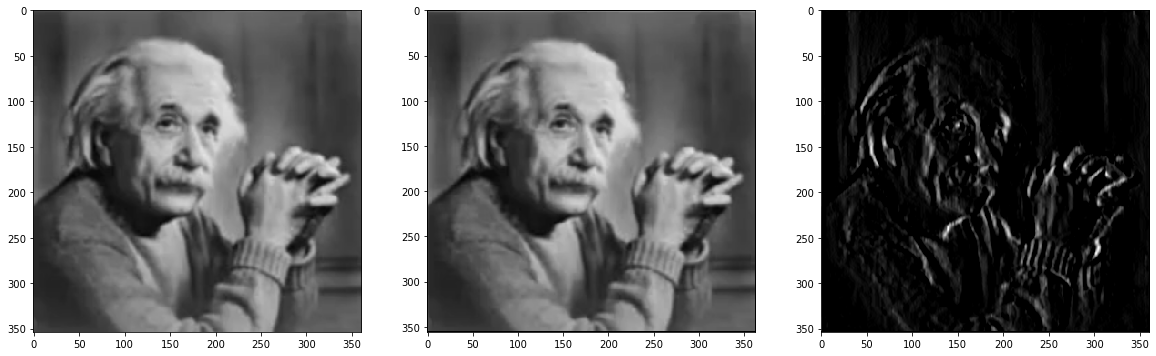

In [237]:
f, ax = plt.subplots(1,3, figsize=(20, 20))
ax[0].imshow(original.astype(int))
ax[1].imshow(padded_image.astype(int))
ax[2].imshow(output.astype(int))
plt.show()